In [11]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from skimage import color, io
from PIL import Image

# Increase the maximum allowed image pixels
Image.MAX_IMAGE_PIXELS = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


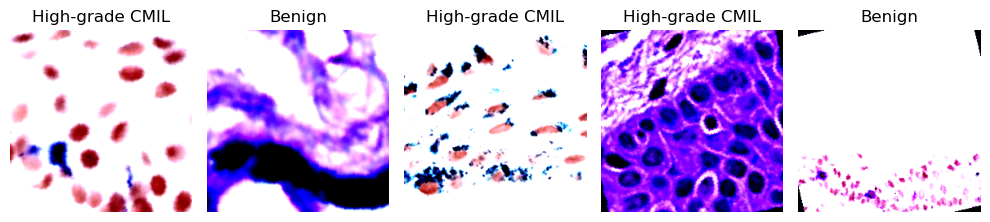

In [14]:

# Load labels

labels = pd.read_csv('/Users/harveywang/Downloads/case_grade_match.csv')  # Replace with your path

# Group patches by case
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            case_patches.setdefault(case_num, []).append(os.path.join(patch_dir, filename))
    return case_patches

# Dataset definition

class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1  # Label benign as 0, high-grade CMIL as 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and split data

image_folder_path = '/Users/harveywang/Library/CloudStorage/GoogleDrive-harveywang2026@u.northwestern.edu/My Drive/Northwestern/Coursework/2025 Spring/STAT 390/filtered_patches'  # Replace with your path
patches = group_patches(image_folder_path)

case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

dataset = dataset[dataset.Class != 2.0]  # Remove low-grade CMIL
X = dataset.Case.reset_index(drop=True)
y = dataset.Class.reset_index(drop=True)

train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

train_patches = {case_num: patches[int(case_num)] for case_num in train_X}
val_patches = {case_num: patches[int(case_num)] for case_num in val_X}
test_patches = {case_num: patches[int(case_num)] for case_num in test_X}

train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=eval_transform)
test_dataset = PNGDataset(test_patches, labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize training samples

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [15]:
def get_predictions(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [16]:
from torchvision import models
import torch.nn as nn

from torchvision import models
import torch.nn as nn
from collections import OrderedDict
import torch

# Rebuild EfficientNet-B2 with your custom classifier
model = models.efficientnet_b2(weights=None)  # No pretrained weights since you're loading your own
num_classes = 2
num_ftrs = model.classifier[1].in_features

model.classifier = nn.Sequential(
    OrderedDict([
        ("fc", nn.Linear(num_ftrs, num_classes)),
        ("output", nn.LogSoftmax(dim=1)),
    ])
)

# Load best saved weights
model.load_state_dict(torch.load("./models/best_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
# Get true and predicted labels
true_labels, pred_labels = get_predictions(model, val_loader)  # or val_loader

# If binary classification, use average='binary'; for multiclass use 'macro' or 'weighted'
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')
accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7228
Precision: 0.7862
Recall:    0.8737
F1 Score:  0.8276


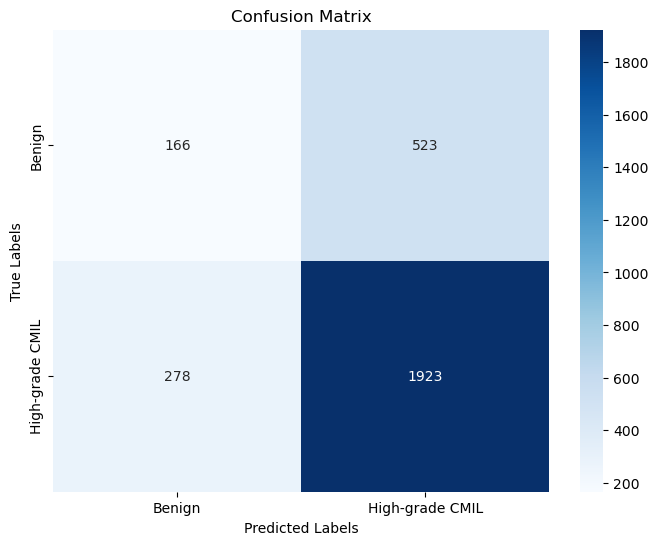

In [20]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.37      0.24      0.29       689
   Malignant       0.79      0.87      0.83      2201

    accuracy                           0.72      2890
   macro avg       0.58      0.56      0.56      2890
weighted avg       0.69      0.72      0.70      2890

